In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

from libs.TrafficGenerator import DatasetConvertor 
from libs.TrafficPredictor.ContextPredictorLstm import PreparingDataset as PreparingDatasetLstm
from libs.TrafficPredictor.ContextPredictorLstm import trainModelByDefaultSetting as trainModelLstm
from libs.TrafficPredictor.ContextPredictorLstm import evaluateModel as evaluateModelLstm
from libs.TrafficPredictor.ContextPredictorLstm import createModel as createModelLstm
from libs import encode_float_filename, decode_float_filename

In [2]:
stringFile = encode_float_filename(0.5)
floatFile = decode_float_filename(stringFile)
print(stringFile)
print(floatFile)

5_00e-01.txt
0.5


In [3]:
dbParams = 0.01
direction = "forward"
#dbParams = 0.2
#direction = "backward"
mode = "fixed"

rawDatasetFolder = "Dataset"
datasetConverter = DatasetConvertor(rawDatasetFolder)
datasetConverter.processDataset(dbParameter=dbParams, alpha=dbParams, mode="fixed", direction=direction)
thumbUnit = datasetConverter.getDataUnit('thumb_fr')
#thumbUnit = datasetConverter.getDataUnit('thumb_bk')

========== thumb ============
Forward: Compression rate:0.22314470485360394
========== index ============
Forward: Compression rate:0.24555334544091786
========== middle ============
Forward: Compression rate:0.24907031047306064


In [4]:
lenWindow = 10
trainDataAugment = True
verbose = True

paramsLstm = {}
paramsLstm['lenSource'] = lenWindow
paramsLstm['lenTarget'] = lenWindow
paramsLstm['trainRatio'] = 0.55
paramsLstm['dataAugment'] = trainDataAugment
paramsLstm['smoothFc'] = 1.5
paramsLstm['smoothOrder'] = 3
trainData, testData = PreparingDatasetLstm(thumbUnit, paramsLstm, verbose=verbose)

(sources, target) = trainData
print(sources.shape)
print(target.shape)

Train size: 57236, Test size: 46831
(57216, 10, 3)
(57216, 10, 3)


In [ ]:
bestWeightsLstm, _, _, modleParametersLstm = trainModelLstm(
paramsLstm['lenSource'], paramsLstm['lenTarget'], trainData, testData, verbose=verbose)

Size of train loader: 14, Size of test loader: 12
Used device: cuda
Size of model: 47499
Seq2Seq(
  (encoder): Encoder(
    (lstm_layers): ModuleList(
      (0): LSTM(3, 12, bidirectional=True)
      (1-5): 5 x LSTM(24, 12, bidirectional=True)
    )
    (ln_layers): ModuleList(
      (0-5): 6 x LayerNorm((24,), eps=1e-05, elementwise_affine=True)
    )
    (residual_projections): ModuleList(
      (0): Linear(in_features=3, out_features=24, bias=True)
      (1-5): 5 x None
    )
  )
  (decoder): Decoder(
    (lstm_layers): ModuleList(
      (0): LSTM(3, 24)
      (1-5): 5 x LSTM(24, 24)
    )
    (ln_layers): ModuleList(
      (0-5): 6 x LayerNorm((24,), eps=1e-05, elementwise_affine=True)
    )
    (residual_projections): ModuleList(
      (0): Linear(in_features=3, out_features=24, bias=True)
      (1-5): 5 x None
    )
    (fc_out): Linear(in_features=24, out_features=3, bias=True)
  )
)


Train size: 52033, Test size: 52034
actual_class_shape: (1732, 1), predicted_class_shape: (1732, 31)


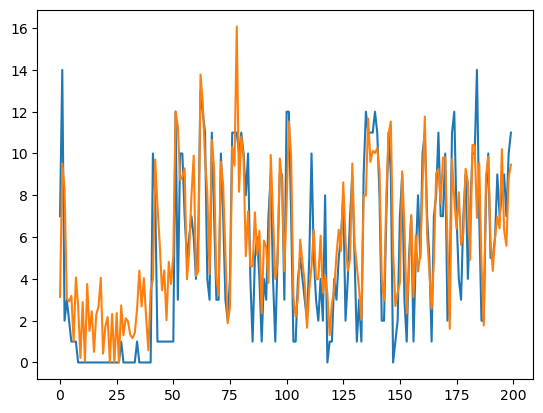

In [ ]:
trafficModelLstm, _ = createModelLstm(modleParametersLstm)
trafficModelLstm.load_state_dict(bestWeightsLstm)

paramsValid = paramsLstm.copy()
paramsValid['dataAugment'] = False
trainData, testData = PreparingDatasetLstm(thumbUnit, paramsValid, verbose=verbose)
#(actual_trafficCA_train, predicted_trafficCA_train, actual_class_train, predicted_class_train, _, _, _, _)  = evaluateModelCA(trafficModelCA, trainData)
#(actual_trafficCA_test, predicted_trafficCA_test, actual_class_test, predicted_class_test, _, _, _, _)  = evaluateModelCA(trafficModelCA, trainData)
resultsTrain = evaluateModelLstm(trafficModelLstm, trainData)
resultsTest = evaluateModelLstm(trafficModelLstm, testData)

print(f"actual_class_shape: {resultsTrain['classDistribu_actual'].shape}, predicted_class_shape: {resultsTrain['classDistribu_predicted'].shape}")

plt.plot(resultsTest['trafficTarget_actual'][0:200])
plt.plot(resultsTest['trafficTarget_predicted'][0:200])

In [ ]:
'''
dbpString = encode_float_filename(dbParams)
with open(f"Results/TrafficPredictor/evaluate/{direction}_{lenWindow}_{mode}_{dbpString}_train.pkl", "wb") as file:
    pickle.dump(resultsTrain, file)
with open(f"Results/TrafficPredictor/evaluate/{direction}_{lenWindow}_{mode}_{dbpString}_test.pkl", "wb") as file:
    pickle.dump(resultsTest, file)

#modelData = {}
#modelData["trainData"] = trainData
#modelData["testData"] = testData
#with open(f"Results/TrafficPredictor/modelData/{direction}_{lenWindow}_{mode}_{dbpString}.pkl", "wb") as file:
#    pickle.dump(modelData, file)
with open(f"Results/TrafficPredictor/modelParams/{direction}_{lenWindow}_{mode}_{dbpString}.pkl", "wb") as file:
    pickle.dump(modleParametersLstm, file)
torch.save(bestWeightsLstm, f"Results/TrafficPredictor/model/{direction}_{lenWindow}_{mode}_{dbpString}.pth")
'''